In [1]:
'''
author: Yike Xie
data: 12/16/2023
content: DEG analysis between single cells and doublets in batch 1
'''

'\nauthor: Yike Xie\ndata: 12/16/2023\ncontent: DEG analysis between single cells and doublets in batch 1\n'

In [2]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import skimage

import scanpy as sc
import pickle

import cv2

/home/yike/.conda/envs/scanpy/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/yike/.conda/envs/scanpy/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/yike/.conda/envs/scanpy/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/yike/.conda/envs/scanpy/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/yike/.conda/envs/scanpy/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `annda

In [3]:
# load batch1 dataset
adata = sc.read_h5ad('/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/gene_filter.h5ad')

# normalization
sc.pp.normalize_total(adata, target_sum=1e6)

#filter genes
sc.pp.filter_genes(adata, min_cells=10)

In [7]:
save_path = '/home/yike/phd/cancer_cells_img_seq/figures/1st_review_202411_Genome_research/'

## single cells vs doublets

In [13]:
single_cells = adata.obs[adata.obs['doublets'].isin(['No', 'single_doublet'])].index.tolist()
doublets = adata.obs[adata.obs['doublets'] == 'Yes'].index.tolist()

In [14]:
from scipy.stats import ks_2samp

df = pd.DataFrame(index = adata.var_names, 
                  columns = ['statistic', 'pvalue', 'statistic_location', 'statistic_sign'])
for gene in adata.var_names:
    res = ks_2samp(adata[doublets, gene].X[:,0], adata[single_cells, gene].X[:, 0], 
                alternative='two-sided', method='asymp')
    df.loc[gene] = [res.statistic, res.pvalue, res.statistic_location, res.statistic_sign]    

## log2 fold change
df['Avg_exp (single_cells)'] = adata[single_cells, ].X.mean(axis=0)
df['Avg_exp (doublets)'] = adata[doublets, ].X.mean(axis=0)
df['Log2FC (doublets vs single_cells)'] =  np.log2(df['Avg_exp (doublets)']+ 1) - np.log2(df['Avg_exp (single_cells)'] + 1)

from statsmodels.stats.multitest import multipletests
adjust_pvalue = multipletests(df['pvalue'], alpha=0.05, method='fdr_bh')[1] # pvals_corrected Benjamini/Hochberg (non-negative)
df['pvalue_corrected (Benjamini/Hochberg)'] = adjust_pvalue

df.to_csv(save_path + 'DEGs_batch1_doublets_vs_singlecells_signed_ks.tsv', sep='\t')

In [15]:
## define upregulated and downreglated genes

df = pd.read_csv(save_path + 'DEGs_batch1_doublets_vs_singlecells_signed_ks.tsv', sep='\t', index_col=0)
df['signed_statistic'] = df['statistic'] * df['statistic_sign'] * -1
df['R'] = np.sqrt(df['signed_statistic'] ** 2 + df['Log2FC (doublets vs single_cells)'] ** 2)
df['N_exp'] = (adata.X > 0).sum(axis=0)

## filter genes without median as 0 in both subgroups
filtered_genes_idx = (np.median(adata[single_cells,].X, axis=0) != 0) * (np.median(adata[doublets,].X, axis=0) != 0)
filtered_genes = adata.var_names[filtered_genes_idx] # 3680
df_filtered = df.loc[filtered_genes]

## adjust pvalue
from statsmodels.stats.multitest import multipletests
adjust_pvalue = multipletests(df_filtered['pvalue'], alpha=0.05, method='fdr_bh')[1] # pvals_corrected Benjamini/Hochberg (non-negative)
df_filtered['pvalue_corrected'] = adjust_pvalue

In [16]:
df_filtered['Log2FC (doublets vs single_cells)'].sort_values(ascending=False).head(100).index

Index(['PDE8A', 'DDA1', 'UBA3', 'SCAF11', 'STYX', 'RBMS1', 'BMPR2', 'XBP1',
       'RNF130', 'METTL14', 'DNMT1', 'TRAP1', 'DUSP23', 'NRIP1', 'DTYMK',
       'ATG13', 'SNX17', 'SOS1', 'RAF1', 'FBXO21', 'GNAI2', 'FOXJ3', 'MKNK1',
       'IKZF5', 'SIPA1L1', 'VEZT', 'PCNXL4', 'LMNA', 'TRPT1', 'FAM210B',
       'NIPA2', 'ATP6V0D1', 'SLC7A6', 'RBM42', 'MRPS11', 'PIAS1', 'RHOBTB3',
       'UBALD2', 'RLIM', 'ABHD11', 'TMUB1', 'PSENEN', 'DRG1', 'ASAP2', 'RBBP5',
       'THOC2', 'KPNA1', 'LMBR1', 'DDX21', 'CAAP1', 'CREBBP', 'TADA1', 'UBE2Z',
       'HEATR5B', 'KIAA2018', 'MED13L', 'COPA', 'MICA', 'STAMBP', 'DPM3',
       'NAPG', 'NCOA2', 'HNRNPLL', 'EMD', 'PRSS8', 'SEC31A', 'TRAFD1', 'TUFT1',
       'DNAJC8', 'NBEAL1', 'KCNQ1OT1', 'ABHD12', 'NFIC', 'UEVLD', 'SMARCD1',
       'ARFGEF1', 'SEC24C', 'ZHX3', 'TIMM50', 'IREB2', 'TSKU', 'ABHD2', 'KLC2',
       'EIF3L', 'TPP1', 'PRPF19', 'GOT2', 'USP22', 'LATS1', 'CUX1', 'SGMS1',
       'TP53INP1', 'ZBTB7A', 'STK38', 'UGDH', 'IMPDH2', 'NEAT1', 'TFRC',
 

**cell cycle genes upregulated in doublets:**

1. Genes related to the cell cycle:
- DNMT1: Maintains DNA methylation patterns during replication, which is crucial for cell cycle progression and genome stability.
- RBMS1: A DNA-binding protein that influences DNA replication and cell proliferation.
- LMNA: Lamin A/C proteins are key components of the nuclear envelope, with roles in nuclear structure and chromatin organization during mitosis.
- TADA1: Part of the transcriptional machinery that can regulate genes involved in proliferation and the cell cycle.
- RBBP5: A core component of the MLL/SET histone methyltransferase complex, which regulates gene expression during the cell cycle.
- TRAP1: A mitochondrial chaperone that supports energy metabolism and cellular stress response, indirectly affecting the cell cycle.
- DTYMK: Involved in deoxythymidine monophosphate synthesis, which is critical for DNA replication and S-phase progression.
- PIAS1: Functions as a SUMO ligase, influencing cell cycle regulatory proteins through post-translational modification.
- UBALD2: Associated with ubiquitin signaling, a pathway critical for protein degradation during cell cycle transitions.
- RNF130: A ubiquitin ligase that might regulate proteins involved in cell cycle control.
- ASAP2: Involved in signaling pathways that impact cell adhesion and migration, indirectly influencing the cell cycle.
2. Other notable genes with potential indirect roles in the cell cycle:
- EYA3: Acts as a transcriptional coactivator and can influence growth-related genes.
- RAF1: Part of the MAPK signaling pathway, which is crucial for cell proliferation and survival.
- TXN2: A thioredoxin involved in oxidative stress response, indirectly affecting cell survival and replication.
- DRG1: Plays a role in cellular growth and proliferation.

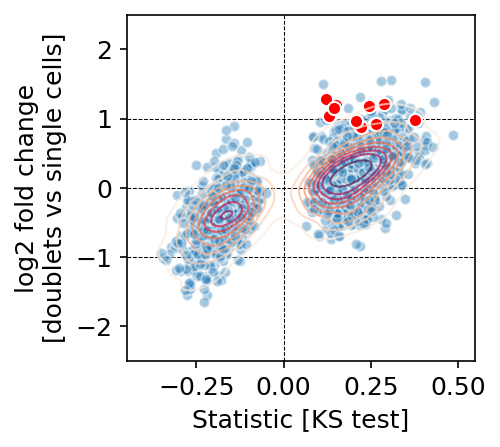

In [19]:
## plotting

y = df_filtered['Log2FC (doublets vs single_cells)']
x = df_filtered['signed_statistic']

rcParams['pdf.fonttype'] = 42
rcParams['font.sans-serif'] = ['DejaVu Sans']  # Set a fallback font
rcParams['font.family'] = 'sans-serif'
rcParams['font.size'] = 12

fig, ax = plt.subplots(figsize=[3, 3], dpi=150)

sns.kdeplot(data=df_filtered, 
            x='signed_statistic', y='Log2FC (doublets vs single_cells)', 
            linestyles='solid', linewidths=1,
            cmap='rocket_r', alpha=0.7, ax=ax) # cmap='rocket_r',

ax.scatter(x, y, alpha=0.4, s=25, edgecolor='white')

ax.axvline(0, ls='--', lw=0.5, c='k', zorder=0)
for i in [-1, 0, 1]:
    ax.axhline(i, ls='--', lw=0.5, c='k', zorder=0)

ax.set(xlabel='Statistic [KS test]', 
       ylabel='log2 fold change\n[doublets vs single cells]', 
       xlim=[-0.45, 0.55], ylim=[-2.5, 2.5])

labeled_gs = [
    'DNMT1','RBMS1','LMNA','TADA1','RBBP5','TRAP1','DTYMK','PIAS1','UBALD2','RNF130','ASAP2',
    #'EYA3','RAF1','TXN2','DRG1',  
]
ax.scatter(x.loc[labeled_gs], y.loc[labeled_gs], s=40, 
                   facecolor='red', edgecolor='w')
        
plt.savefig(save_path + 'DEGs_batch1_db_vs_sc_statistic.pdf', 
            bbox_inches='tight')
plt.savefig(save_path + 'DEGs_batch1_db_vs_sc_statistic.png', 
            bbox_inches='tight')

In [20]:
df_filtered.loc[
    ['DNMT1','RBMS1','LMNA','TADA1','RBBP5','TRAP1','DTYMK','PIAS1','UBALD2','RNF130','ASAP2',]
].sort_values('signed_statistic')

,statistic,pvalue,statistic_location,statistic_sign,Avg_exp (single_cells),Avg_exp (doublets),Log2FC (doublets vs single_cells),pvalue_corrected (Benjamini/Hochberg),signed_statistic,R,N_exp,pvalue_corrected
gene_name,,,,,,,,,,,,
RBMS1,0.121864,0.877388,18.040302,-1,28.710680,71.567560,1.288343,1.000000,0.121864,1.294094,73,0.995697
LMNA,0.130227,0.824210,313.794220,-1,119.014090,245.325880,1.037365,1.000000,0.130227,1.045507,78,0.975096
DTYMK,0.145759,0.710519,27.480299,-1,85.069435,190.129260,1.150976,1.000000,0.145759,1.160168,75,0.931205
DNMT1,0.149343,0.682778,47.828583,-1,39.686190,92.082794,1.193975,1.000000,0.149343,1.203279,62,0.920638
UBALD2,0.207885,0.283046,0.000000,-1,34.349167,67.895370,0.962731,1.000000,0.207885,0.984920,74,0.782924
TADA1,0.222222,0.216030,89.969590,-1,110.177120,204.168880,0.883952,1.000000,0.222222,0.911457,69,0.756376
TRAP1,0.243728,0.138986,49.709908,-1,41.181957,94.280290,1.175551,1.000000,0.243728,1.200552,83,0.664662
RBBP5,0.262843,0.090628,26.869543,-1,79.350760,151.893690,0.928145,1.000000,0.262843,0.964645,73,0.620775
ASAP2,0.266428,0.083334,2.057778,-1,31.891705,61.590750,0.928226,1.000000,0.266428,0.965705,74,0.620775


## brightfield of doublets

In [21]:
adata_db = adata[adata.obs['doublets'] == 'Yes']

In [22]:
def cell_labels(seg_fn):    
    print('import segmentated figure')
    if '_T' in seg_fn:
        seg = cv2.imread(seg_fn, 2).T # 1: color, 2: gray
    else:
        seg = cv2.imread(seg_fn, 2)

    print('get labels of each cell')
    from skimage.segmentation import watershed
    
    markers = np.zeros_like(seg)
    markers[seg == 2] = 1
    markers[seg == 1] = 2
    markers = np.nan_to_num(markers, nan=0).astype(int)
    
    segmentation = watershed(seg, markers)

    from scipy import ndimage as ndi
    segmentation = ndi.binary_fill_holes(segmentation - 1)

    labeled, _ = ndi.label(segmentation)
    return seg, labeled

def get_segmentation(seg, labeled, n_ls):
    
    raw = seg.copy()
    px = [np.bincount(labeled.ravel()).argsort()[::-1][int(i)] for i in n_ls]
    raw[ ~ np.isin(labeled, px)] = 2
    cell_seg = raw == 1
    
    return cell_seg
    
################################################
print('load segmentation information')
df = adata_db.obs.copy()
grids = np.unique(df['grid'].to_list()).tolist()

n_cells = {}
for grid in grids:
    n_cells[grid] = {}
    cells = df[df['grid'] == grid].index

    for cell in cells:
        if ',' in df.loc[cell]['#feature']:
            n_ls = df.loc[cell]['#feature'].split(',')
        else:
            n_ls = [df.loc[cell]['#feature']]
        n_cells[grid][cell] = n_ls

load segmentation information


In [84]:
# add brightfield images to npz files

png_fdn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_imaging/brightfield/adjusted/'
cropped_cells = '/home/yike/phd/cancer_cells_img_seq/figures/batch_202112/segmentation/cancer100cells/doublets/'
seg_fdn = '/home/yike/phd/cancer_cells_img_seq/figures/batch_202112/hyperspectral_images/good_seg/'

fns = [i for i in os.listdir(seg_fdn) if 'tiff' in i]

for grid in grids:
    sample = plt.imread(os.path.join(png_fdn, grid + '.png'))
    
    # get rough segmentation for the whole grid
    fn = [f'{grid}_Simple Segmentation.tiff', f'{grid}_Simple Segmentation_T.tiff'][f'{grid}_Simple Segmentation_T.tiff' in fns]
    seg_grid, labeled = cell_labels(seg_fdn + fn)
    
    names = adata_db.obs[adata_db.obs['grid'] == grid].index
    for name in names:
        
        if name in ['G3_S5', 'M9_S89', 'N9_S90', 'F10_S95', 'I12_S124']:
            # crop and add it into the npz file of cropped single cells
            n_ls = n_cells[grid][name]
            seg = get_segmentation(seg_grid, labeled, n_ls)

            print('find ROI...')
            i0s = seg.any(axis=1).nonzero()[0]
            i1s = seg.any(axis=0).nonzero()[0]
            i00, i01 = i0s[0], i0s[-1] + 1
            i10, i11 = i1s[0], i1s[-1] + 1

            print('add margins...')

            # rewrite like if name in []: margin_px is another number

            margin_px = 30

            i00 = max(0, i00 - margin_px)
            i10 = max(0, i10 - margin_px)
            i01 = min(seg.shape[0], i01 + margin_px)
            i11 = min(seg.shape[1], i11 + margin_px)

            print('crop brightfield...')
            cropped_cell = np.load(os.path.join(cropped_cells, '{}.npz'.format(name)))
            img_dict = dict(cropped_cell.items())
            img_dict['brightfield'] = sample[i00: i01, i10: i11]

            print('save croped control to file...')
            np.savez_compressed(os.path.join(cropped_cells, '{}.npz'.format(name)), **img_dict)

import segmentated figure
get labels of each cell
find ROI...
add margins...
crop brightfield...
save croped control to file...
import segmentated figure
get labels of each cell
import segmentated figure
get labels of each cell
import segmentated figure
get labels of each cell
import segmentated figure
get labels of each cell
import segmentated figure
get labels of each cell
import segmentated figure
get labels of each cell
import segmentated figure
get labels of each cell
find ROI...
add margins...
crop brightfield...
save croped control to file...
find ROI...
add margins...
crop brightfield...
save croped control to file...
import segmentated figure
get labels of each cell
import segmentated figure
get labels of each cell
import segmentated figure
get labels of each cell
import segmentated figure
get labels of each cell
import segmentated figure
get labels of each cell
find ROI...
add margins...
crop brightfield...
save croped control to file...
find ROI...
add margins...
crop bright

In [23]:
def adjusted_cropped_cell(npz_fdn, sample, length):
        
    image = np.load(npz_fdn + sample + '.npz')
    
    mask_o = image['new_segmentation'].copy()
    bf_o = image['brightfield'].copy()

    # width and height of the original figure
    w, h = mask_o.shape

    # width range
    mw1 = int(length/2 - round(w/2))
    mw2 = int(mw1 + w)
    # height range
    mh1 = int(length/2 - round(h/2))
    mh2 = int(mh1 + h)

    # create a template for brightfield
    # color is defined as average of brightfield
    bf = np.empty((length, length, 4))
    for i in range(4):
        bf[:, :, i] = bf_o[:, :, i].mean()

    # replace the brightfield template with cell
    bf[mw1: mw2, mh1: mh2, :] = bf_o
    
    # create a template for mask
    mask = np.zeros([length, length, 4])
    mask[mw1: mw2, mh1: mh2, 2][mask_o] = 1 # blue
    mask[mw1: mw2, mh1: mh2, 3][mask_o] = 0.1 # transparency

    return {'bf': bf, 'mask': mask}

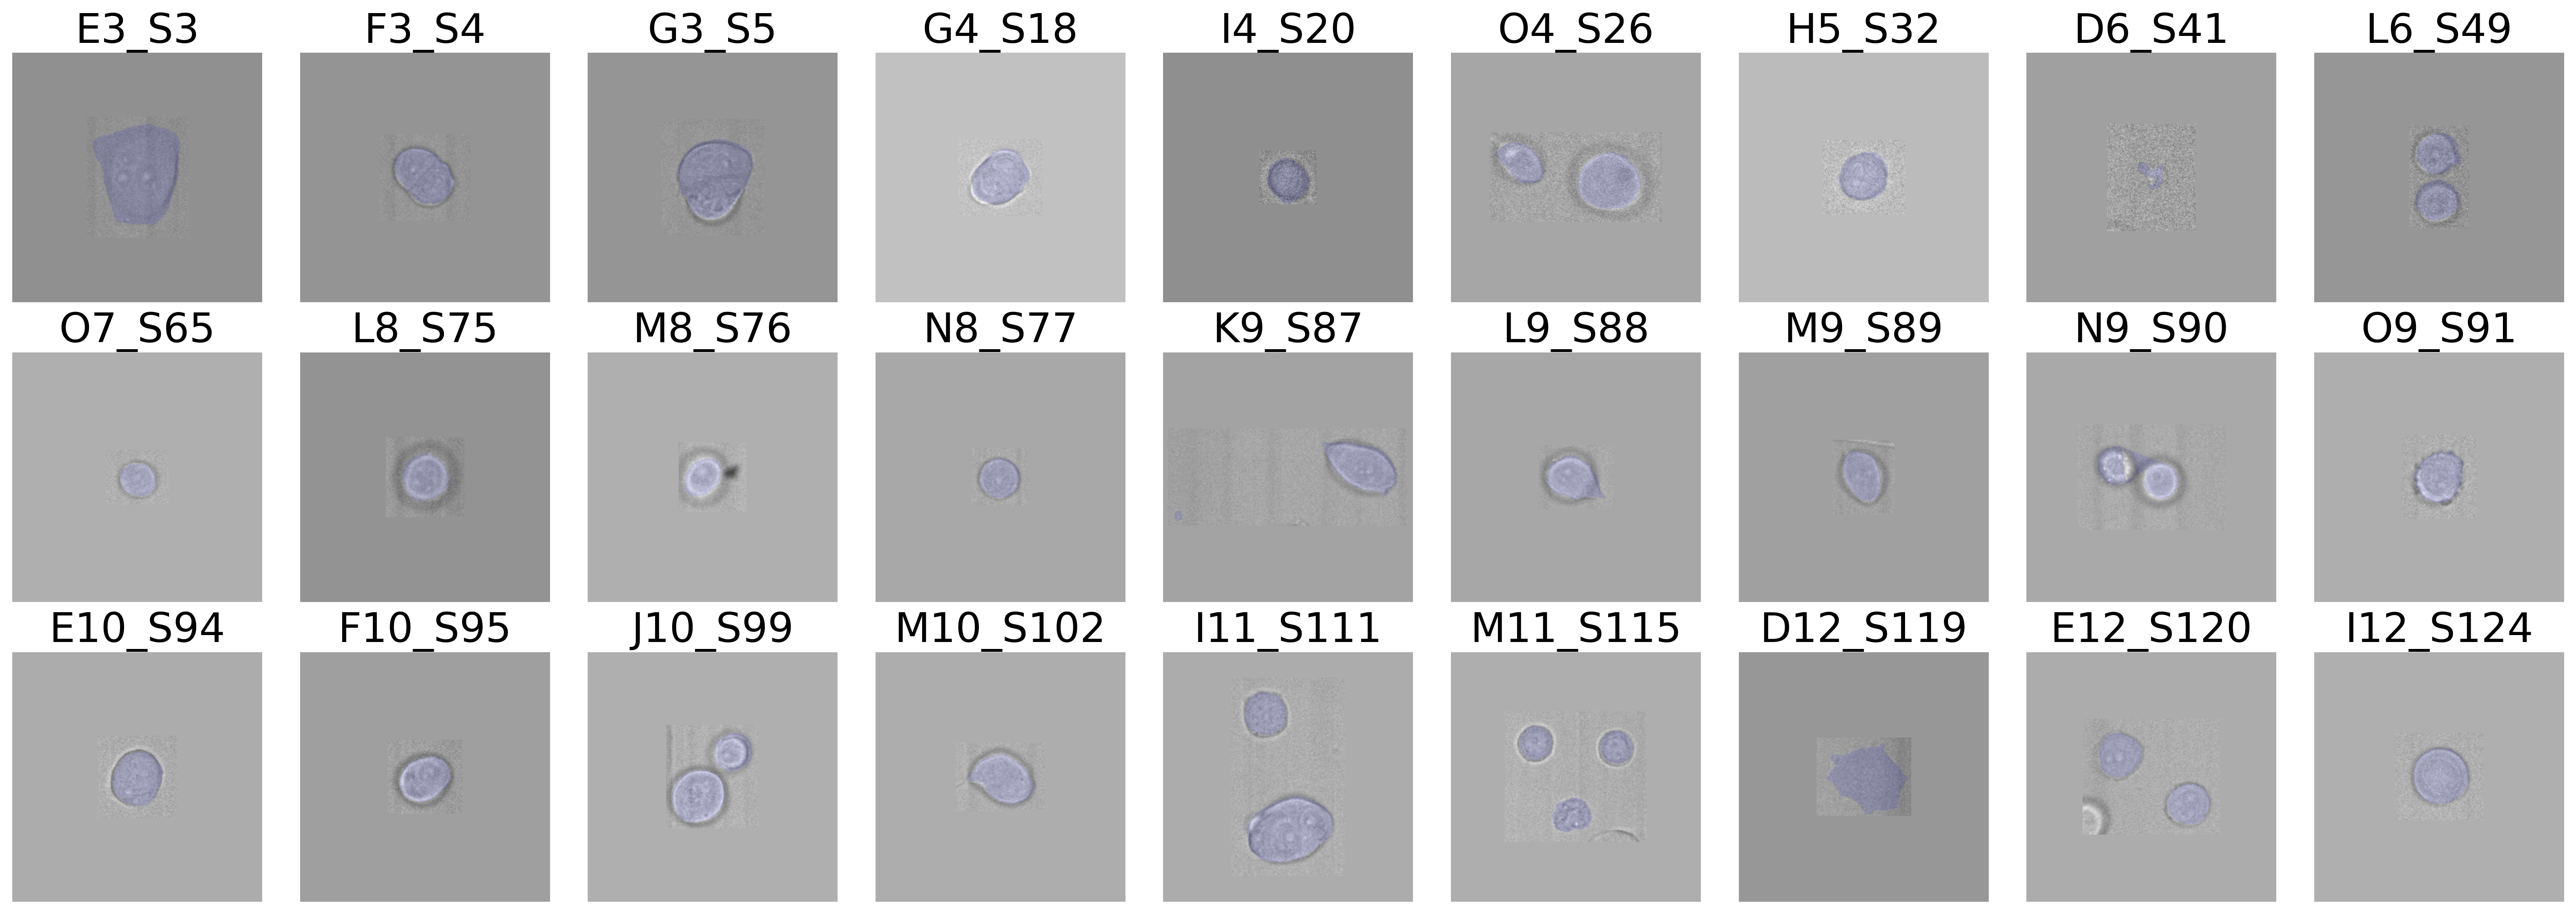

In [30]:
# supplementary figure with all cells
npz_fdn = '/home/yike/phd/cancer_cells_img_seq/figures/batch_202112/segmentation/cancer100cells/doublets/'
save_path = '/home/yike/phd/cancer_cells_img_seq/figures/1st_review_202411_Genome_research/'

hn = 9
vn = 3

fig, axs = plt.subplots(vn, hn, figsize=(3 * hn, 3 * vn), 
                        dpi=300, sharex=True, sharey=True)    
rcParams['pdf.fonttype'] = 42
length = 1300
plt.subplots_adjust(wspace=0.1, hspace=0.2)

axs = axs.ravel()
for i in range(hn * vn):
    if i in range(adata_db.obs.shape[0]):
        sample = adata_db.obs_names[i]

        bf, mask = adjusted_cropped_cell(npz_fdn, sample, length).values()
        
        axs[i].imshow(bf)
        axs[i].set_title(sample, fontsize=24)
        axs[i].imshow(mask)

    axs[i].axis('off')

fig.savefig(save_path + 'supplementary_doublets_size2.pdf')
fig.savefig(save_path + 'supplementary_doublets_size2.png', dpi=600)